In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('NF-BoT-IoT.csv')

In [3]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600095,192.168.100.46,80,192.168.100.5,80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,192.168.100.5,0,192.168.100.3,0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,192.168.100.7,365,192.168.100.3,565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,192.168.100.3,50850,13.54.166.67,8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [4]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [5]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [6]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [7]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [8]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.30.71.205:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,172.22.205.114:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,172.16.254.35:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,172.22.5.214:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,172.28.109.226:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
600095,172.27.199.25:80,192.168.100.5:80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,172.17.10.55:0,192.168.100.3:0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,172.19.215.174:365,192.168.100.3:565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,172.22.193.116:50850,13.54.166.67:8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [9]:
data.drop(columns=['Label'],inplace = True)

In [10]:
data.rename(columns={"Attack": "label"},inplace = True)

In [11]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [12]:
label = data.label

In [13]:
data.drop(columns=['label'],inplace = True)

In [14]:
scaler = StandardScaler()

In [15]:
data =  pd.concat([data, label], axis=1)

In [16]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.30.71.205:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0
1,172.22.205.114:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,4
2,172.16.254.35:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0
3,172.22.5.214:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0
4,172.28.109.226:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0
...,...,...,...,...,...,...,...,...,...,...,...
600095,172.27.199.25:80,192.168.100.5:80,6,7.000,2330065,0,2523,0,0,4263037,0
600096,172.17.10.55:0,192.168.100.3:0,6,0.000,1054423,0,1513,0,0,4263062,0
600097,172.19.215.174:365,192.168.100.3:565,17,0.000,62422,0,1357,0,0,4263062,0
600098,172.22.193.116:50850,13.54.166.67:8883,6,222.178,11300,1664,32,32,24,4264935,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [ ]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [19]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [20]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [21]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,h
592389,172.16.85.185:57470,192.168.100.3:80,0.256954,-1.668013,-0.010775,-0.007610,0.002649,-0.008687,-1.420647,-2.082482,3,"[-1.6680129931210856, -1.4206468963806982, -0...."
541914,172.28.105.64:53426,192.168.100.3:80,0.256954,-1.668013,-0.015998,-0.007551,-0.021496,-0.003471,-1.558214,-2.082482,1,"[-1.6680129931210856, -1.5582144503945237, -0...."
393332,172.23.240.164:60855,192.168.100.6:9080,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3,"[0.5654513605460513, 0.6760250962126005, -0.01..."
180488,172.22.160.164:14323,192.168.100.3:12139,0.256954,0.565451,-0.017440,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3,"[0.5654513605460513, 0.6760250962126005, -0.01..."
207769,172.18.143.56:40317,192.168.100.5:5357,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3,"[0.5654513605460513, 0.6760250962126005, -0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...
96131,172.18.160.8:57963,192.168.100.5:1027,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496290,3,"[0.5654513605460513, 0.6760250962126005, -0.01..."
583684,172.26.6.39:54248,192.168.100.3:80,0.256954,-1.668013,-0.016132,-0.007551,-0.021496,-0.003471,-1.558214,-2.082482,1,"[-1.6680129931210856, -1.5582144503945237, -0...."
599529,172.27.201.8:43797,192.168.100.150:4433,0.256954,0.565451,-0.017403,-0.008378,-0.045641,-0.024336,0.676025,0.496292,4,"[0.5654513605460513, 0.6760250962126005, -0.01..."
352726,172.25.137.48:33197,192.168.100.5:90,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496289,3,"[0.5654513605460513, 0.6760250962126005, -0.01..."


In [22]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [23]:
G = G.to_directed()


In [24]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [25]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [26]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [27]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [28]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [29]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [30]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [31]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [32]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [34]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(G.edata['label'].cpu().numpy()),
                                                 y=G.edata['label'].cpu().numpy())

In [35]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [36]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [37]:
G.ndata['h'].device


device(type='cuda', index=0)

In [38]:
G.edata['h'].device


device(type='cuda', index=0)

In [39]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,4000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.7619444131851196
Training acc: 0.7430570721626282
Training acc: 0.7631882429122925
Training acc: 0.6992810368537903
Training acc: 0.7662222981452942
Training acc: 0.6625074148178101
Training acc: 0.7688860893249512
Training acc: 0.7244637608528137
Training acc: 0.7584997415542603
Training acc: 0.7679362893104553
Training acc: 0.7707655429840088
Training acc: 0.7773025631904602
Training acc: 0.7785523533821106
Training acc: 0.7826790809631348
Training acc: 0.7781131267547607
Training acc: 0.770541787147522
Training acc: 0.779931902885437
Training acc: 0.770497739315033
Training acc: 0.7752957344055176
Training acc: 0.7659366130828857
Training acc: 0.7712571620941162
Training acc: 0.7443235516548157
Training acc: 0.7823588848114014
Training acc: 0.7845727801322937
Training acc: 0.7842704653739929
Training acc: 0.7830551862716675
Training acc: 0.7799235582351685
Training acc: 0.7835384607315063
Training acc: 0.7659556269645691
Training acc: 0.7739936113357544
Training acc:

In [ ]:
X_test = encoder.transform(X_test)

In [41]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [42]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
508964,172.20.251.23:3851,192.168.100.148:57874,0.256954,0.565451,-0.017440,-0.008374,-0.045641,-0.024336,0.676025,0.496292,3
550351,172.22.28.190:59388,192.168.100.3:80,0.256954,-1.668013,-0.015694,-0.007551,-0.021496,-0.003471,-1.558214,-2.082482,3
126326,172.17.189.90:14903,192.168.100.3:12625,0.256954,0.565451,-0.017440,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3
75198,172.18.109.15:33223,192.168.100.5:2383,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496290,3
459608,172.22.160.66:53308,192.168.100.3:3306,0.256954,0.565451,-0.016705,-0.007860,-0.021496,0.001745,-1.379682,0.496174,3
...,...,...,...,...,...,...,...,...,...,...,...
219108,172.19.197.177:45576,192.168.100.3:1114,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3
527997,172.22.245.158:40850,192.168.100.3:60161,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3
38363,172.28.196.195:57088,192.168.100.7:80,0.256954,-1.668013,-0.016455,-0.006905,-0.029544,-0.008687,-1.379682,0.486699,1
159958,172.17.215.45:39747,192.168.100.7:2251,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3


In [43]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [44]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [45]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [46]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [47]:
G_test = G_test.to('cuda:0')


In [48]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [49]:
print(str(elapsed) + ' seconds')


0.23355129999981727 seconds


In [50]:
test_pred = test_pred.argmax(1)


In [51]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [52]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [55]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

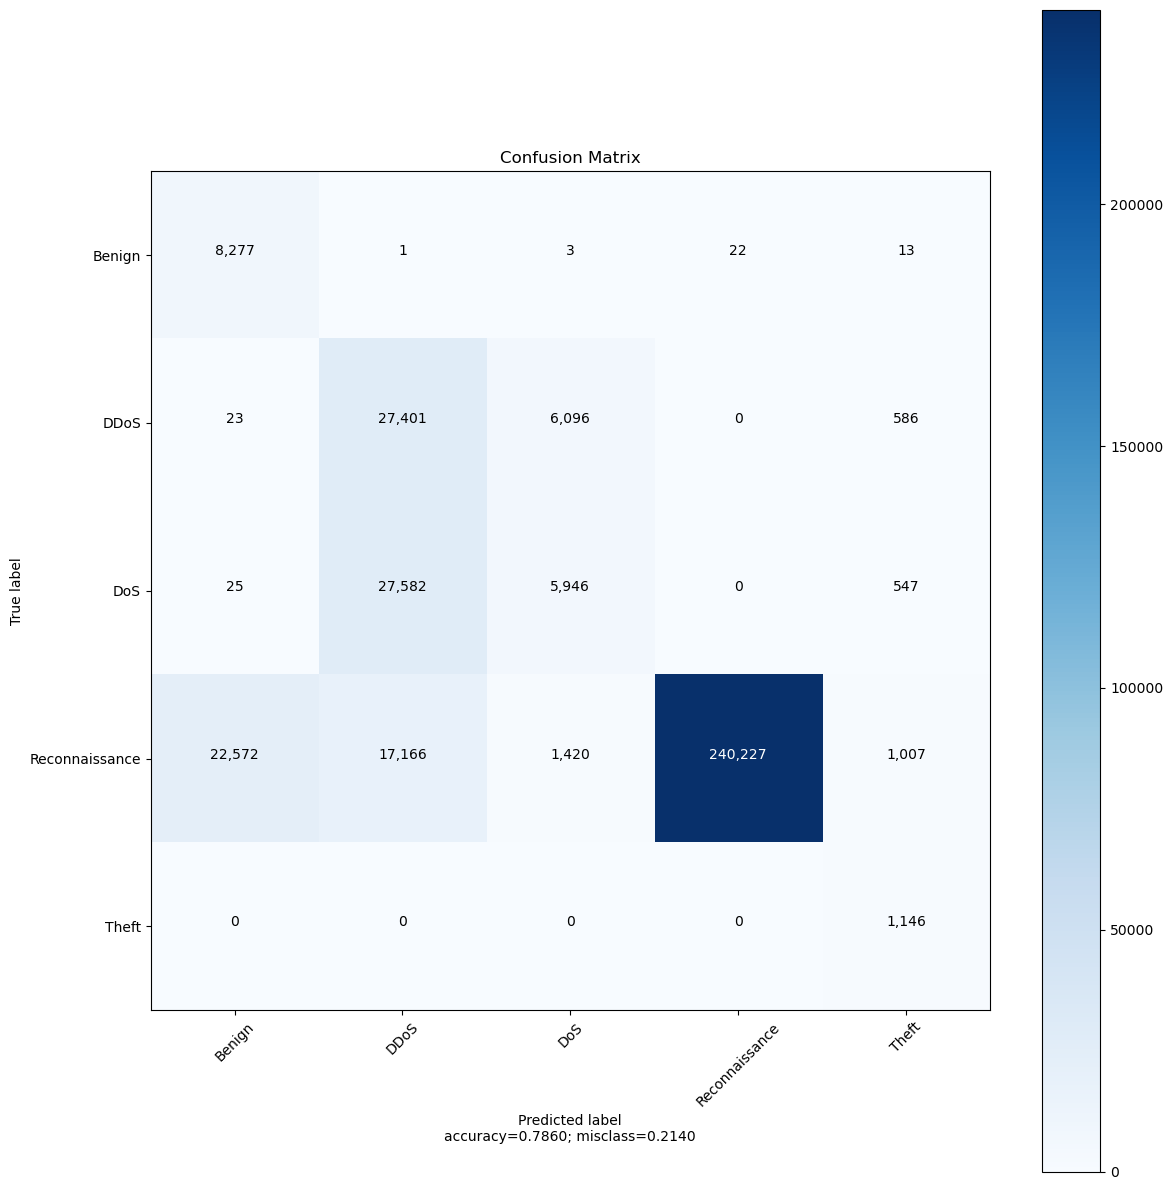

In [56]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")